## Notebook 1: Data Analysis for Customer Retention During Digital Transformation

**Author**: Olga Seymour

**Date**: May 2025

**GitHub**: https://github.com/AI-Data-Space/BankingRetentionOptimizer 

### Business Context

Atlantic Regional Bank is undergoing a digital transformation, shifting from physical branches to digital channels. With this transition comes the risk of customer attrition. While this transformation will reduce operational costs and improve efficiency, it threatens to alienate customers who rely on traditional banking touchpoints. The bank has a limited retention budget of $1.5 million and needs to identify which customers are both likely to leave and most likely to respond to retention efforts.

### Objective

In this notebook, we'll explore the customer dataset to understand patterns and factors influencing churn during digital transformation. These insights will inform our predictive modeling and retention strategy development in later notebooks.

### Data Loading and Initial Exploration

We begin by loading the dataset and examining its basic structure. This helps us understand what information we have available for predicting customer churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
df = pd.read_csv('data/Churn_Modelling.csv')

In [4]:
# EDA 
print(df.head())
print("\nDataset shape:", df.shape)

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

### Data Quality Assessment
Before analysis, we need to check for missing values and understand the overall quality of our dataset. Data quality issues could impact our model's performance.

In [5]:
print("\nMissing values per column:") 
print(df.isnull().sum())


Missing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
print(df.describe())

         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000     

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


## Understanding Churn Rate
The churn rate represents the percentage of customers leaving the bank. Understanding this baseline is crucial for assessing the business problem's magnitude and evaluating our model's impact.

In [8]:
print(df['Exited'].value_counts(normalize=True)*100)

Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


In [9]:
# Look at target variable distribution - need to understand the class imbalance
print(f"\nTarget distribution:")
print(df['Exited'].value_counts())
print(f"Churn rate: {df['Exited'].mean() * 100:.2f}%")


Target distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64
Churn rate: 20.37%


#### Key Finding: Class Imbalance

Our dataset shows class imbalance with approximately 20% of customers churning. This imbalance will need to be addressed in our modeling approach to ensure we can accurately identify the minority class (churning customers).

### Data Preparation
We remove non-informative columns that won't help with prediction and identify the types of features we're working with.

In [10]:
# Removing non-informative columns
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
print("\nColumns after dropping identifiers:", df.columns.tolist())  


Columns after dropping identifiers: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [11]:
# Identifying numerical and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numeric_features)}):", numeric_features)
print(f"Categorical features ({len(categorical_features)}):", categorical_features)


Numerical features (9): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Categorical features (2): ['Geography', 'Gender']


### Visualizing Churn Distribution
Visualizing the target variable helps us better understand the class imbalance in our dataset.

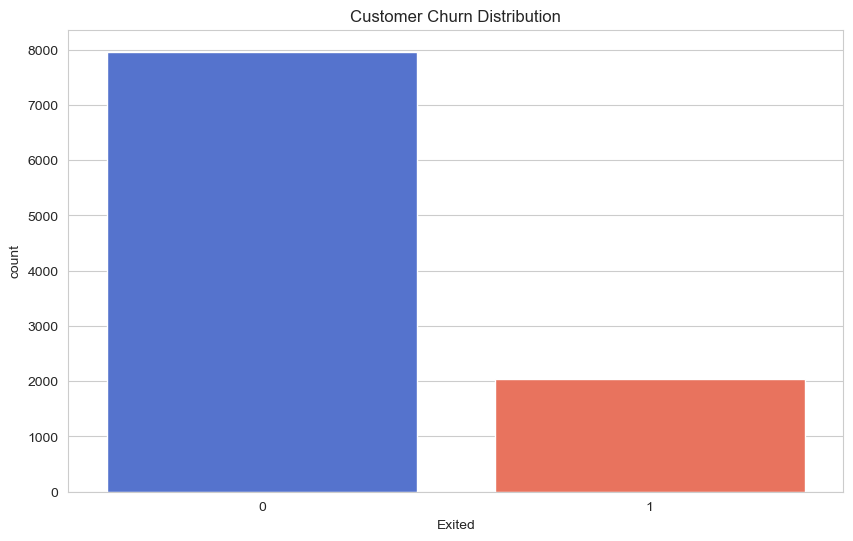

In [12]:
# Visualize target distribution
plt.figure()
sns.countplot(x='Exited', hue='Exited', data=df, palette=['royalblue', 'tomato'], legend=False)
plt.title('Customer Churn Distribution')
plt.savefig('reports/figures/churn_distribution.png')
plt.show()

**Intelligence Extract**: This chart shows the imbalance between customers who stayed (0) and those who exited (1). With approximately 20% of customers churning, we're dealing with an imbalanced classification problem. This imbalance is important to consider when selecting and evaluating our models in Notebook 2, as standard accuracy metrics can be misleading.

### Exploring Categorical Feature Relationships
Categorical features like geography and gender may influence churn probability. We'll analyze how these features relate to customer attrition.

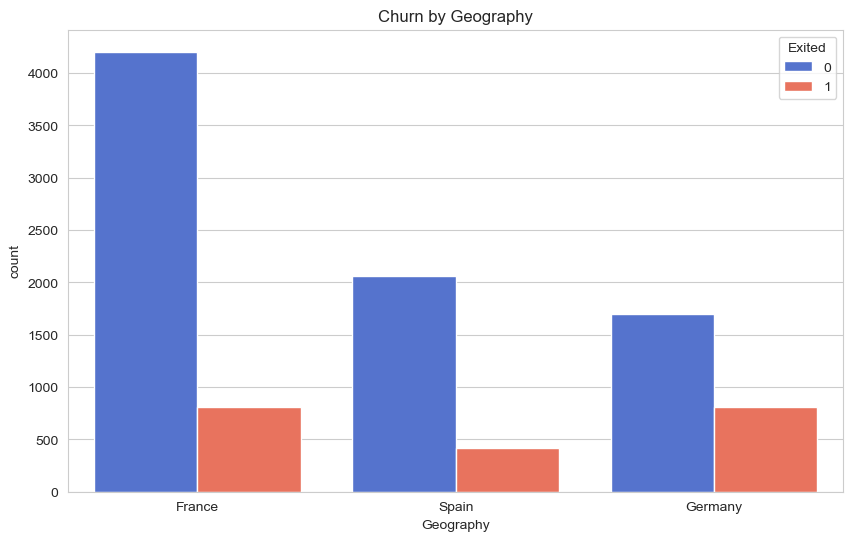

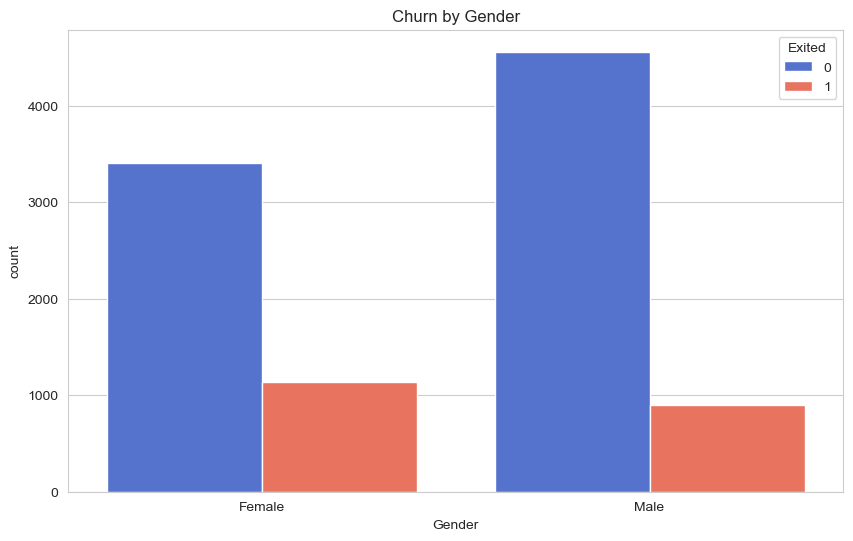

In [13]:
# Explore relationships with target. Explore categorical features
for feature in categorical_features:
    plt.figure()
    sns.countplot(x=feature, hue='Exited', data=df, palette= ['royalblue', 'tomato'])
    plt.title(f'Churn by {feature}')
    plt.savefig(f'reports/figures/churn_by_{feature}.png')
    plt.show()

**Geography Intelligence Analysis**: The charts reveal significant variation in churn rates across regions. Germany shows noticeably higher churn rates than France or Spain, suggesting geographic factors impact retention. This could be due to differences in branch accessibility, digital service quality, or cultural factors affecting banking relationships in different regions.

**Gender-Based Departure Patterns**: Female customers have a slightly higher propensity to churn than male customers. While the difference isn't dramatic, it suggests gender may be a relevant factor in our predictive model and might inform how we tailor retention communications.

### Exploring Numerical Feature Distributions
Numerical features like age, balance, and credit score may show different patterns between churning and retained customers.

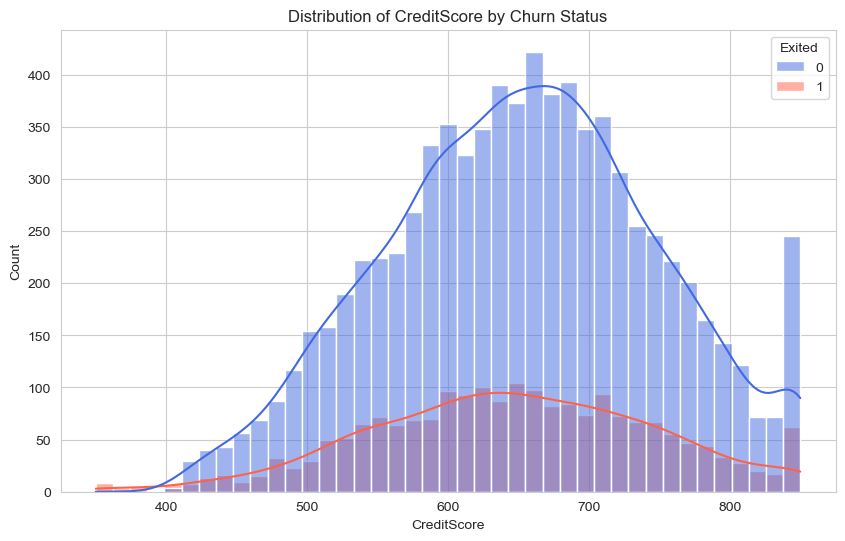

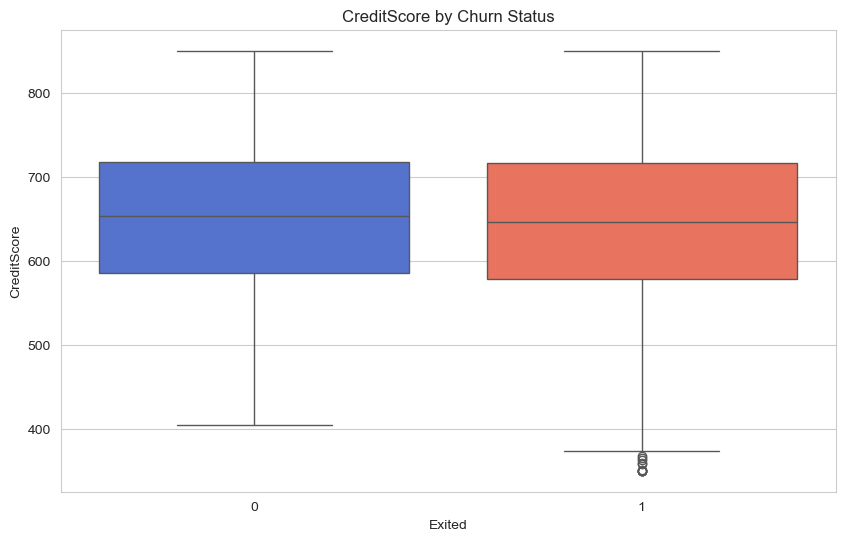

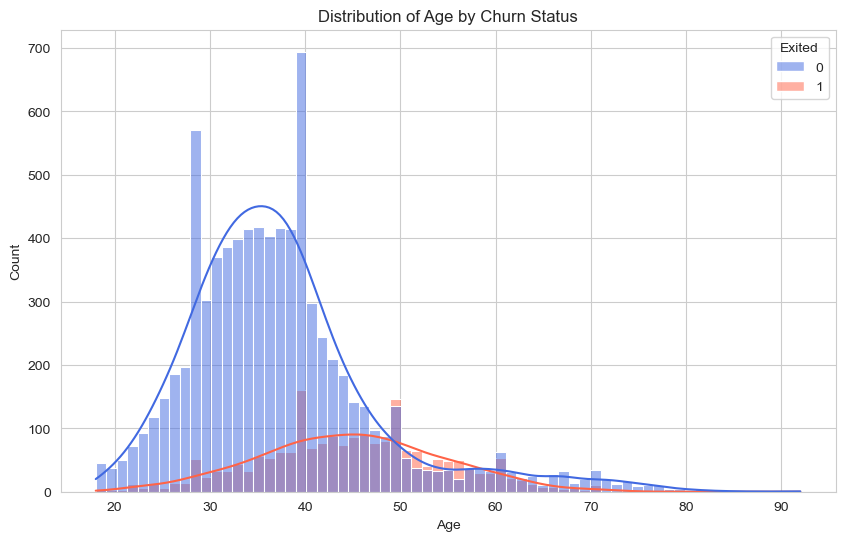

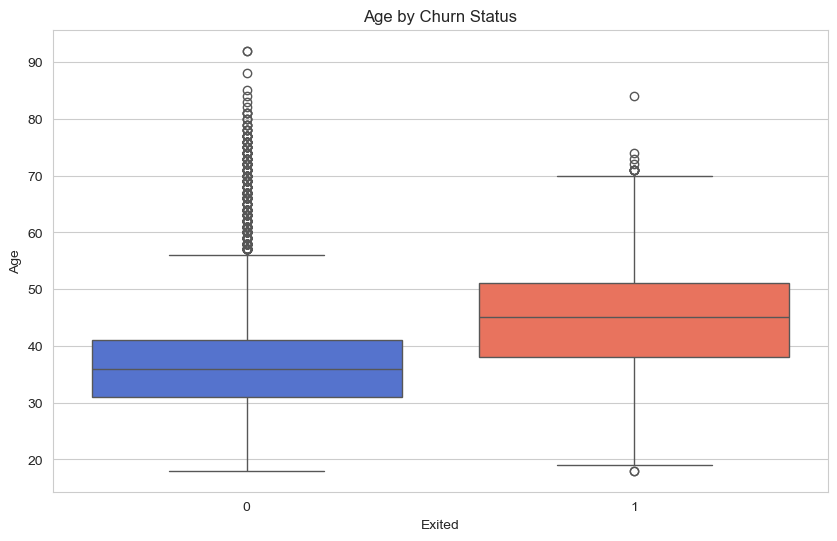

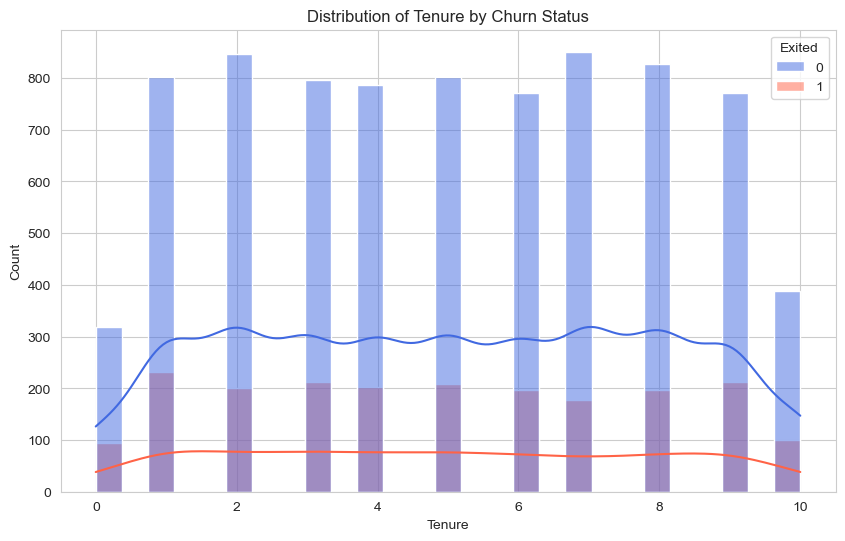

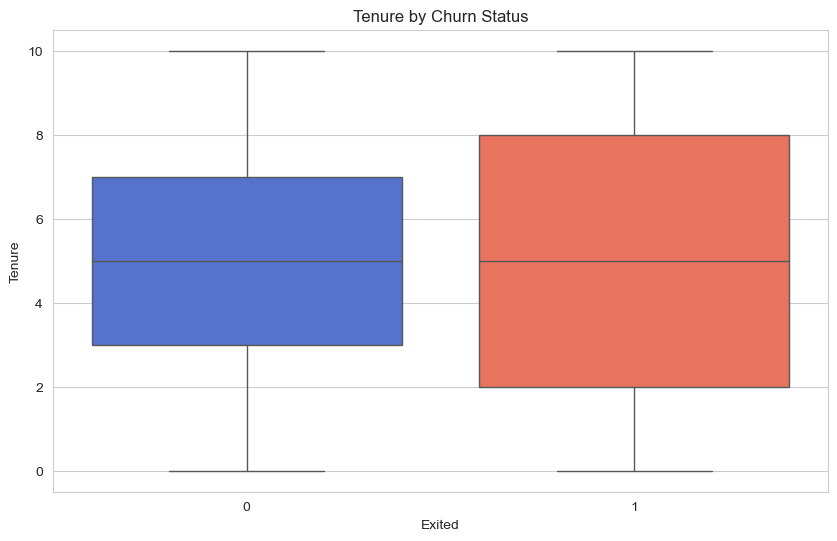

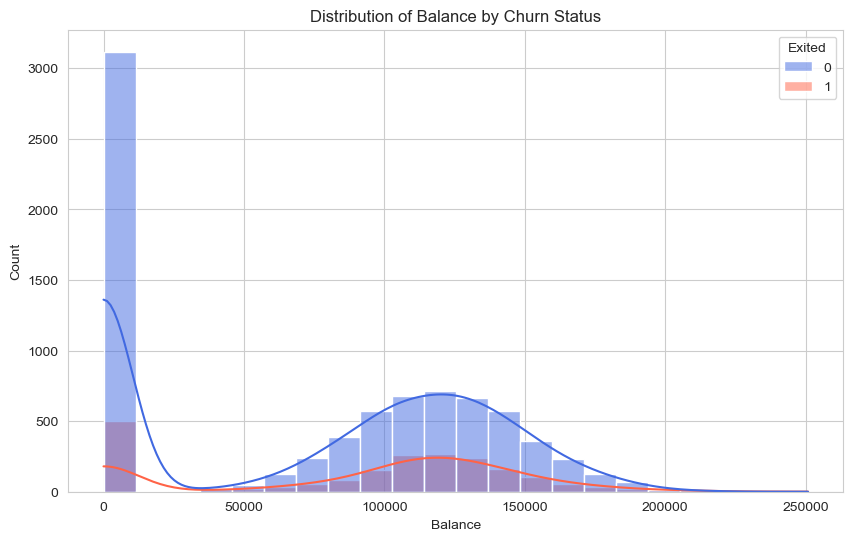

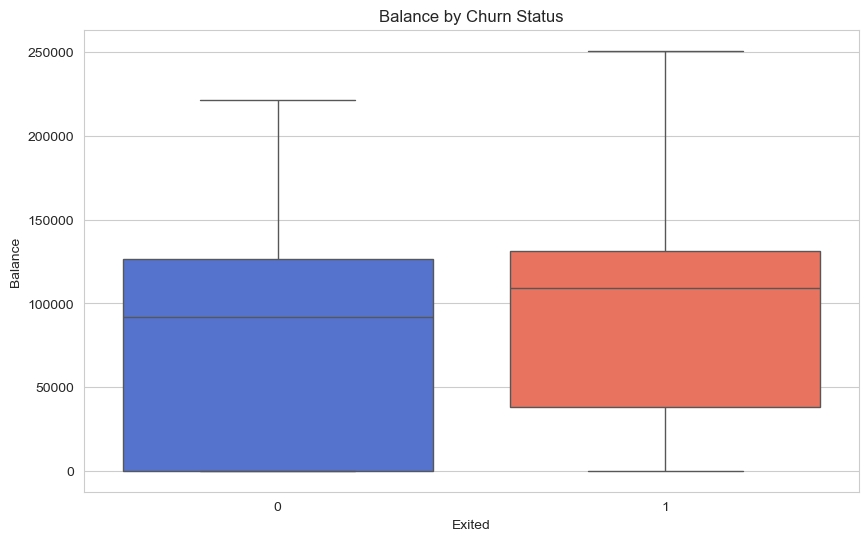

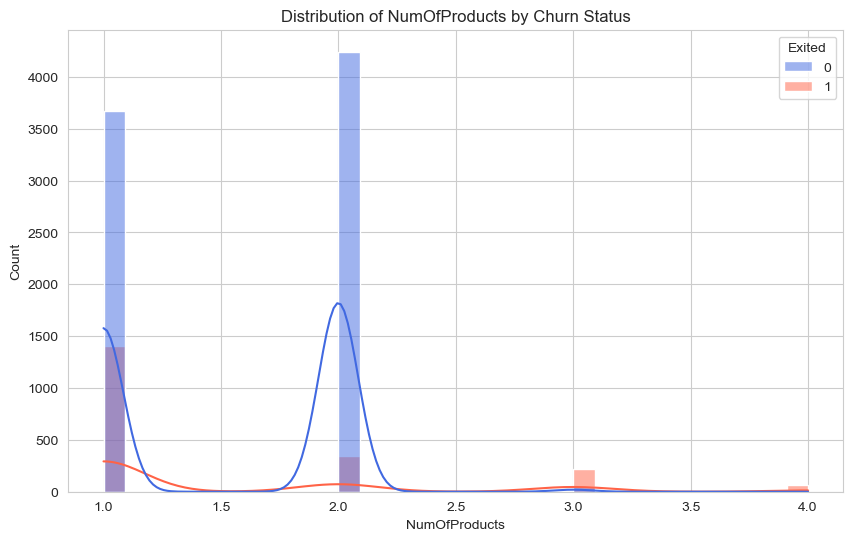

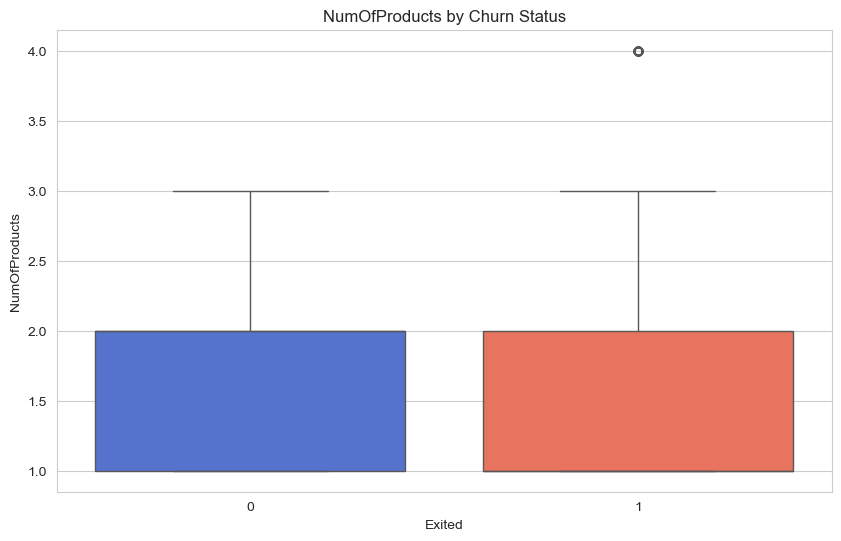

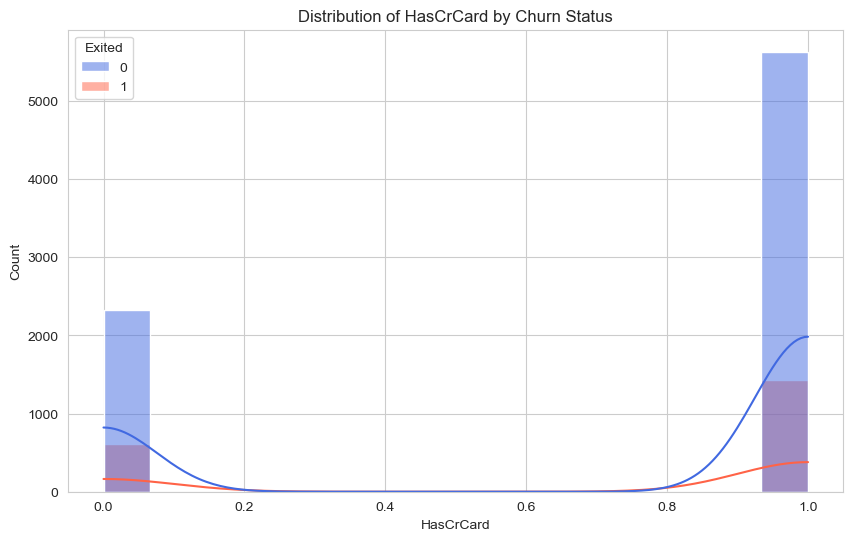

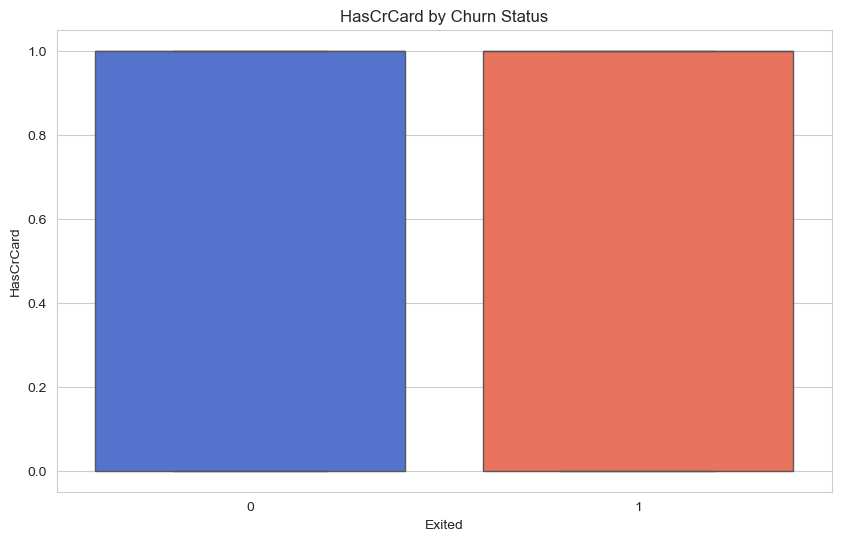

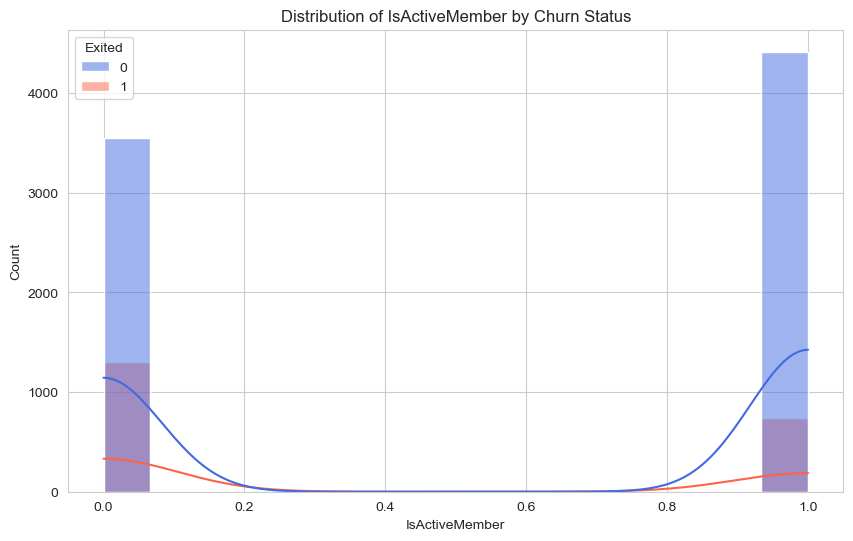

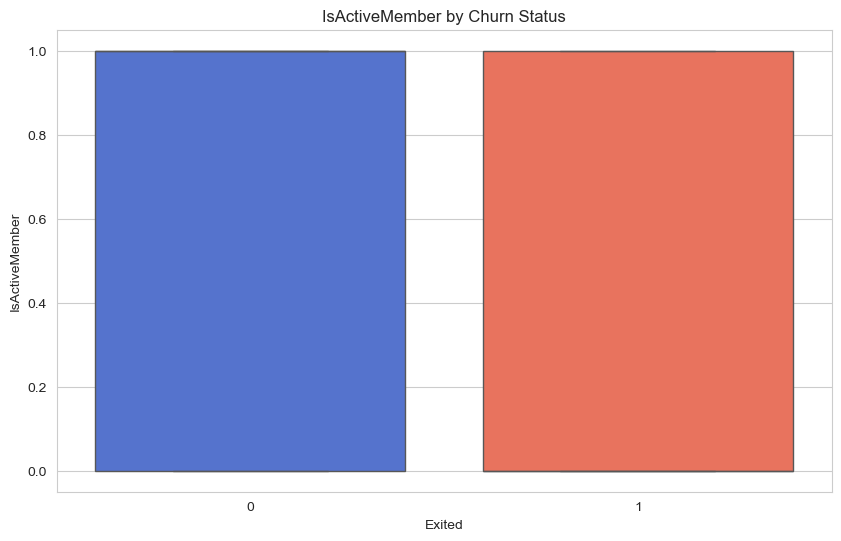

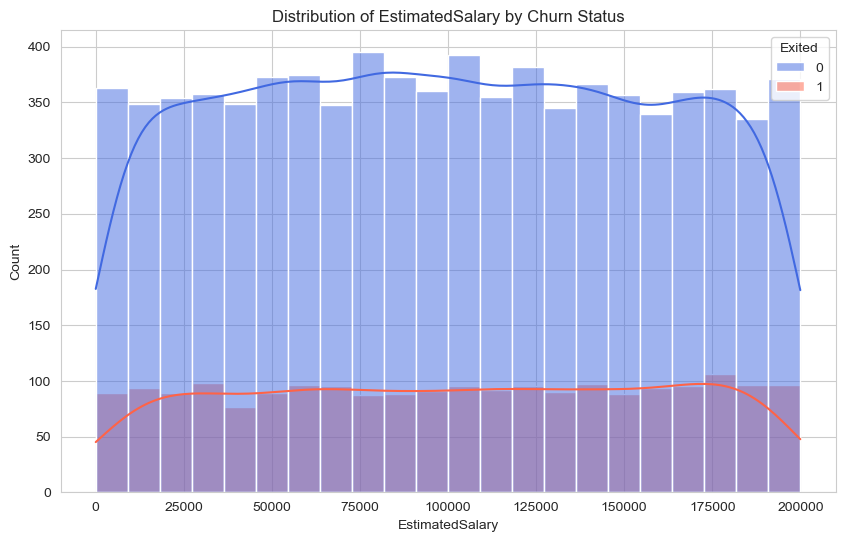

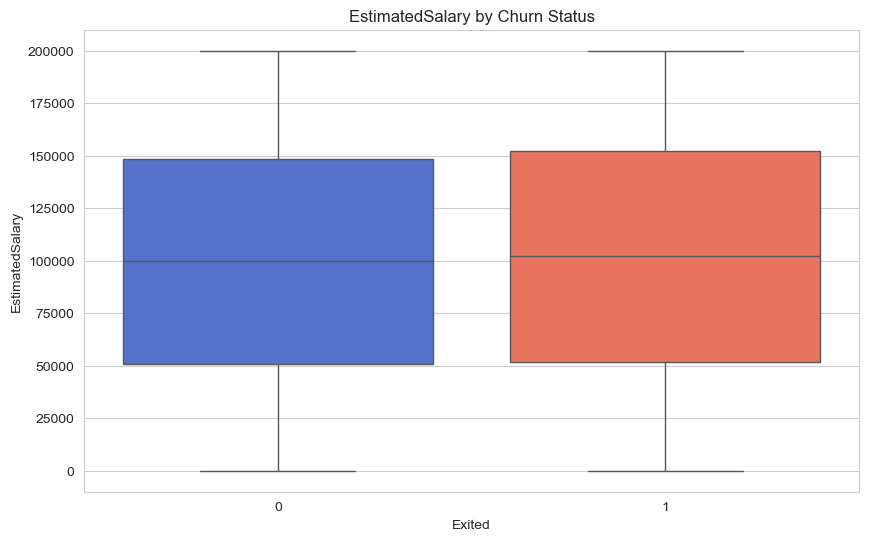

In [14]:
# Explore numerical features
for feature in numeric_features:
    if feature != 'Exited':  # Skip the target
        plt.figure()
        sns.histplot(data=df, x=feature, hue='Exited', kde=True, palette=['royalblue', 'tomato'])
        plt.title(f'Distribution of {feature} by Churn Status')
        plt.savefig(f'reports/figures/dist_{feature}.png')
        plt.show()        
        plt.figure()    
        sns.boxplot(x='Exited', y=feature, hue='Exited', data=df, legend=False, palette=['royalblue', 'tomato'])
        plt.title(f'{feature} by Churn Status')
        plt.savefig(f'reports/figures/boxplot_{feature}.png')
        plt.show()       

**Age Distribution**: The histograms and boxplots reveal a clear pattern: churning customers (red) tend to be older than retained customers (blue). The peak of the churning distribution is in the 40-60 age range, while retained customers have a broader, younger distribution. This is critical for our digital transformation context, as older customers may require more support transitioning to digital channels.

**Balance Distribution**: The balance distribution shows a bimodal pattern for churning customers, with peaks at zero balance and at higher balance amounts. The zero-balance peak suggests inactive accounts are leaving, while the higher-balance pattern indicates we're also losing valuable customers. These different churn drivers will require separate retention strategies.

**Credit Score**: Slight differences in distribution suggest that credit score has some predictive power but isn't as strong an indicator as age or balance.

**NumOfProducts**: Customers with multiple products show significantly lower churn rates, suggesting product diversification is an effective retention strategy.

## Correlation Analysis
Understanding correlations between features helps identify potential multicollinearity and important predictive relationships. Banking relationships involve multiple dimensions that influence departure decisions. We'll analyze how different customer characteristics correlate with departure risk to understand the interconnected factors driving customer loyalty.

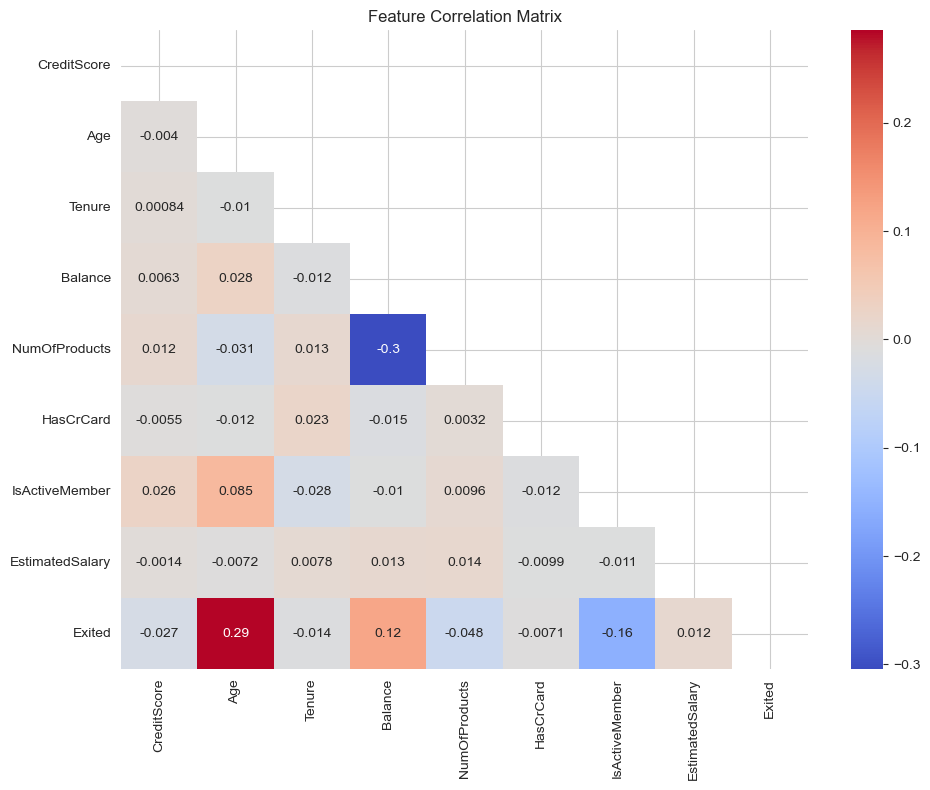

In [15]:
# Correlation analysis for numerical features
plt.figure(figsize=(10, 8))
correlation = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('reports/figures/correlation_matrix.png')
plt.show()

The correlation matrix reveals several important relationships:

**Age and Exited**: The strongest positive correlation with churn is age (0.29), confirming our earlier observation that older customers are more likely to leave.

**NumOfProducts and Exited**: There's a moderate negative correlation (-0.05) between number of products and churn, indicating that customers with more products are less likely to leave. This suggests cross-selling as a potential retention strategy.

**IsActiveMember and Exited**: Active members are significantly less likely to churn (correlation of -0.16), highlighting the importance of engagement.

**Low Multicollinearity**: Most features show low correlation with each other, which is good for modeling as it means our features are capturing different aspects of customer behavior.

### Feature Relationships
Exploring relationships between pairs of features can reveal patterns that might not be apparent when examining features individually.

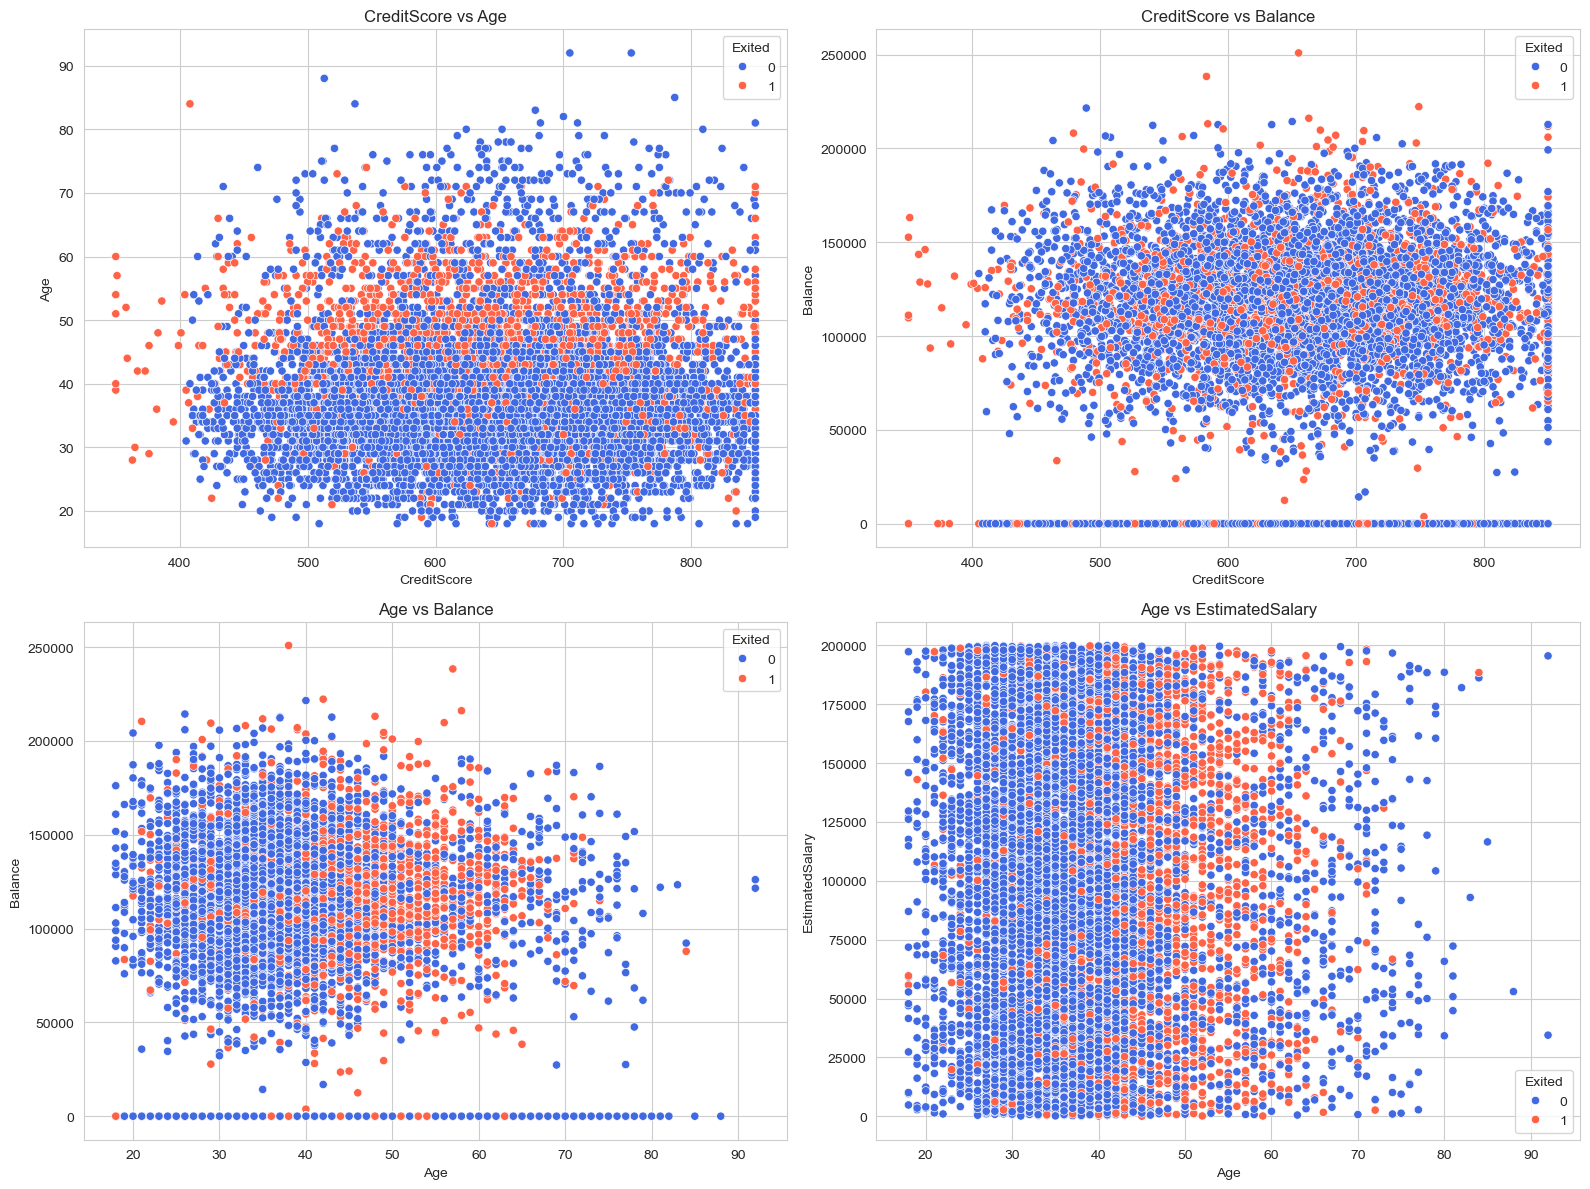

In [16]:
# Feature pair relationships
feature_pairs = [
    ('CreditScore', 'Age'),
    ('CreditScore', 'Balance'),
    ('Age', 'Balance'),
    ('Age', 'EstimatedSalary')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (x_feature, y_feature) in enumerate(feature_pairs):
    sns.scatterplot(
        data=df, 
        x=x_feature, 
        y=y_feature, 
        hue='Exited',
        palette= ['royalblue', 'tomato'],
        ax=axes[i]
    )
    axes[i].set_title(f'{x_feature} vs {y_feature}')

plt.tight_layout()
plt.savefig('reports/figures/feature_relationships.png')
plt.show()

These scatter plots reveal important multi-dimensional relationships:

**Age vs. Balance**: The most striking pattern appears in the Age-Balance relationship, where we can see a distinct cluster of older, higher-balance customers who are churning (red points). This represents a high-value segment requiring targeted retention strategies.

**Credit Score vs. Age**: Older customers with moderate-to-high credit scores show higher churn propensity, indicating that creditworthiness alone isn't keeping these valuable customers.

**Credit Score vs. Balance**: Customers with higher balances show churn risk across the credit score spectrum, suggesting that balance may be a more important factor than credit score for retention.

**Age vs. Salary**: The relationship between age and estimated salary shows that high-income older customers are more likely to churn, representing another high-value segment requiring attention.

These multi-dimensional relationships will be valuable for our segmentation approach in Notebook 3, where we'll develop targeted retention strategies for different customer groups.

### Data Splitting
We split the data into training and test sets, ensuring we preserve the target distribution through stratification. This separation is crucial for unbiased model evaluation.

In [17]:
# Remove target from features first
X = df.drop('Exited', axis=1)
y = df['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 8000
Test set size: 2000


In [18]:
train_df_raw = X_train.copy()
train_df_raw['Exited'] = y_train.values

test_df_raw = X_test.copy()
test_df_raw['Exited'] = y_test.values

# Save the raw splits. We'll apply feature engineering as part of the modeling pipeline 
train_df_raw.to_csv('data/train_raw.csv', index=False)
test_df_raw.to_csv('data/test_raw.csv', index=False)

print("\nData exploration complete.")
print("Raw training data saved to 'data/train_raw.csv'")
print("Raw test data saved to 'data/test_raw.csv'")


Data exploration complete.
Raw training data saved to 'data/train_raw.csv'
Raw test data saved to 'data/test_raw.csv'


### Banking Transformation Intelligence Summary
Our exploratory data analysis has revealed several critical insights that will inform our predictive modeling and retention strategy development:

**Age is a critical factor**: Customers in the 40-60 age range show significantly higher churn probability, suggesting challenges with digital adoption during transformation. The boxplot clearly shows churning customers have a higher median age.

**Inactive accounts are high risk**: The balance distribution shows customers with zero balances are much more likely to leave, representing inactive accounts that may require re-engagement strategies.

**Geography matters**: Churn rates vary significantly by region, with Germany showing noticeably higher rates than France or Spain. This suggests the need for region-specific retention approaches.

**Product holding is protective**: The correlation analysis shows customers with multiple products have lower churn rates (-0.05 correlation), indicating cross-selling as an effective retention strategy.

**Active membership status is crucial**: Inactive members are significantly more likely to leave (-0.16 correlation with churn), highlighting the importance of regular engagement.

**High-value segment at risk**: The scatter plots reveal a concerning pattern of older, higher-balance customers showing elevated churn risk, representing a critical high-value segment requiring special attention.

**Gender differences exist**: Female customers show slightly higher churn rates than male customers, suggesting potential differences in banking preferences or digital adoption patterns.

These insights will ***inform our feature engineering and modeling approach*** in Notebook 2, where we'll develop predictive models to identify customers at high risk of leaving during the digital transformation. In Notebook 3, we'll use these patterns to develop segment-specific retention strategies that address the unique needs of different customer groups.

## Next Steps

**Feature Engineering**: We will create new features that capture ***digital readiness*** and customer value to better target retention efforts.

**Model Development**: Build and compare **machine learning models** to predict which customers are likely to leave.

**Segmentation Strategy**: Develop targeted retention approaches for different customer segments based on both churn risk and digital adoption readiness.

**ROI Analysis**: Calculate the expected return on investment for different retention strategies to optimize our limited $1.5 million budget.